In [1]:
from skimage.measure import block_reduce
import numpy as np

import logging

from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt

from notebook_utils import plot 
import config

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
from utils import data_provider

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped'),
    'mnist-3-digits': data_provider.MNIST3DigitsData(dir_path='../data/mnist'),
    'fashion-mnist-3-items': data_provider.MNIST3DigitsData(dir_path='../data/fashion-mnist'),
}

In [4]:
dataset['fashion-mnist-3-items'].train.x.shape

(48000, 28, 84)

# Define functions

In [5]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [6]:
def get_data_for_class(data_name, class_idx, no=16, seed=2):
    np.random.seed(seed)

    data = dataset[data_name]
    indices = np.argmax(data.test2d.y, axis=1) == class_idx
    if no:
        s = np.random.choice(np.sum(indices), size=no, replace=False)
        return data.test2d.x[indices,:,:][s, :, :]
    else:
        return data.test2d.x[indices,:,:]

In [7]:
mnist_1 = get_data_for_class('mnist-3-digits', 1)
fmnist_1 = get_data_for_class('fashion-mnist-3-items', 1)
mnist_5 = get_data_for_class('mnist-3-digits', 5)

In [8]:
mnist_1_all = get_data_for_class('mnist', 1, no=None)

In [9]:
mnist_1.shape
mnist_1_all.shape

(1135, 28, 28)

In [10]:
def plot_digits(data, title="", show_title=False):
    plt.figure(figsize=(16,4))
    for i in range(data.shape[0]):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:])
        plt.xticks([])
        plt.yticks([])
    if show_title:
        plt.suptitle(title)
    plt.show()

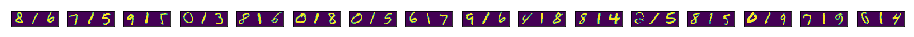

In [11]:
plot_digits(mnist_1, title="MNIST Class 1")

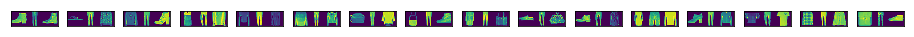

In [12]:
plot_digits(fmnist_1, title="MNIST Class 1")

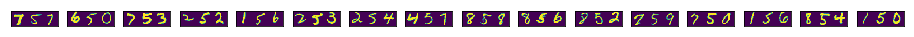

In [13]:
plot_digits(mnist_5, title="MNIST Class 1")

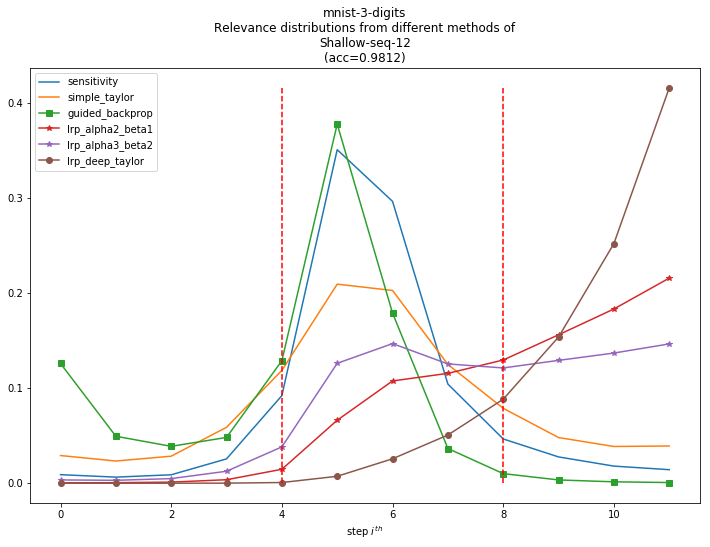

In [14]:
def relevance_distribution(model_path, methods=['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_alpha3_beta2', 'lrp_deep_taylor'], cols=7):
    model_obj = provider.load(model_path)
    data = dataset[model_obj._.dataset]
 
    x, y = data.test2d.x, data.test2d.y
#     x, y = data.test2d.x[:100, :, :], data.test2d.y[:100, :]
    
    plt.figure(figsize=(12,8))
    max_value = 0
    for m in methods:
        _, heatmaps = getattr(model_obj, 'rel_%s' % m)(x,y)

        # select only positive relevance and sum over rows
        positive_relevance = np.sum(heatmaps * (heatmaps > 0), axis=1)
        
        relevance_for_step = np.zeros((x.shape[0], model_obj._.seq_length))
        for i in range(model_obj._.seq_length):
            
            relevance_for_step[:, i] = np.sum(positive_relevance[:, (i*cols):(i+1)*cols], axis=1)
        
        total_relevance = np.sum(relevance_for_step, axis=1).reshape(-1, 1)
        relevance_dist = np.mean(relevance_for_step / (total_relevance + 1e-100), axis=0)

        if max_value < np.max(relevance_dist):
            max_value = np.max(relevance_dist)
        marker = ''
        if 'deep' in m:
            marker='o'
        elif 'lrp' in m:
            marker='*'
        elif 'guided' in m:
            marker='s'
        plt.plot(relevance_dist, label=m, marker=marker)
    max_value + 0.1
    plt.plot([4, 4], [0, max_value], 'r--')
    plt.plot([4*2, 4*2], [0, max_value], 'r--')
    plt.legend()
    plt.title('%s\nRelevance distributions from different methods of\n%s\n(acc=%.4f)'
              % (
                  model_obj._.dataset,
                  model_obj.formal_name(),
                  model_obj._.accuracy
                ))
    plt.xlabel('step $i^{th}$')
    plt.show()
    
relevance_distribution("../experiment-results/3-items-dataset/aws-training/s2_network-mnist-3-digits-seq-12---2018-02-07--11-14-03")

In [15]:
def plot_everything(model, data, seq):
    methods=['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_alpha3_beta2', 'lrp_deep_taylor']
    path = model_path(model, data, seq)
    plot.plot_relevance_methods(path, dataset[data], methods=methods, only_positive_rel = True) 
    
    relevance_distribution(path, methods=methods)

# Results

## Shallow architecture

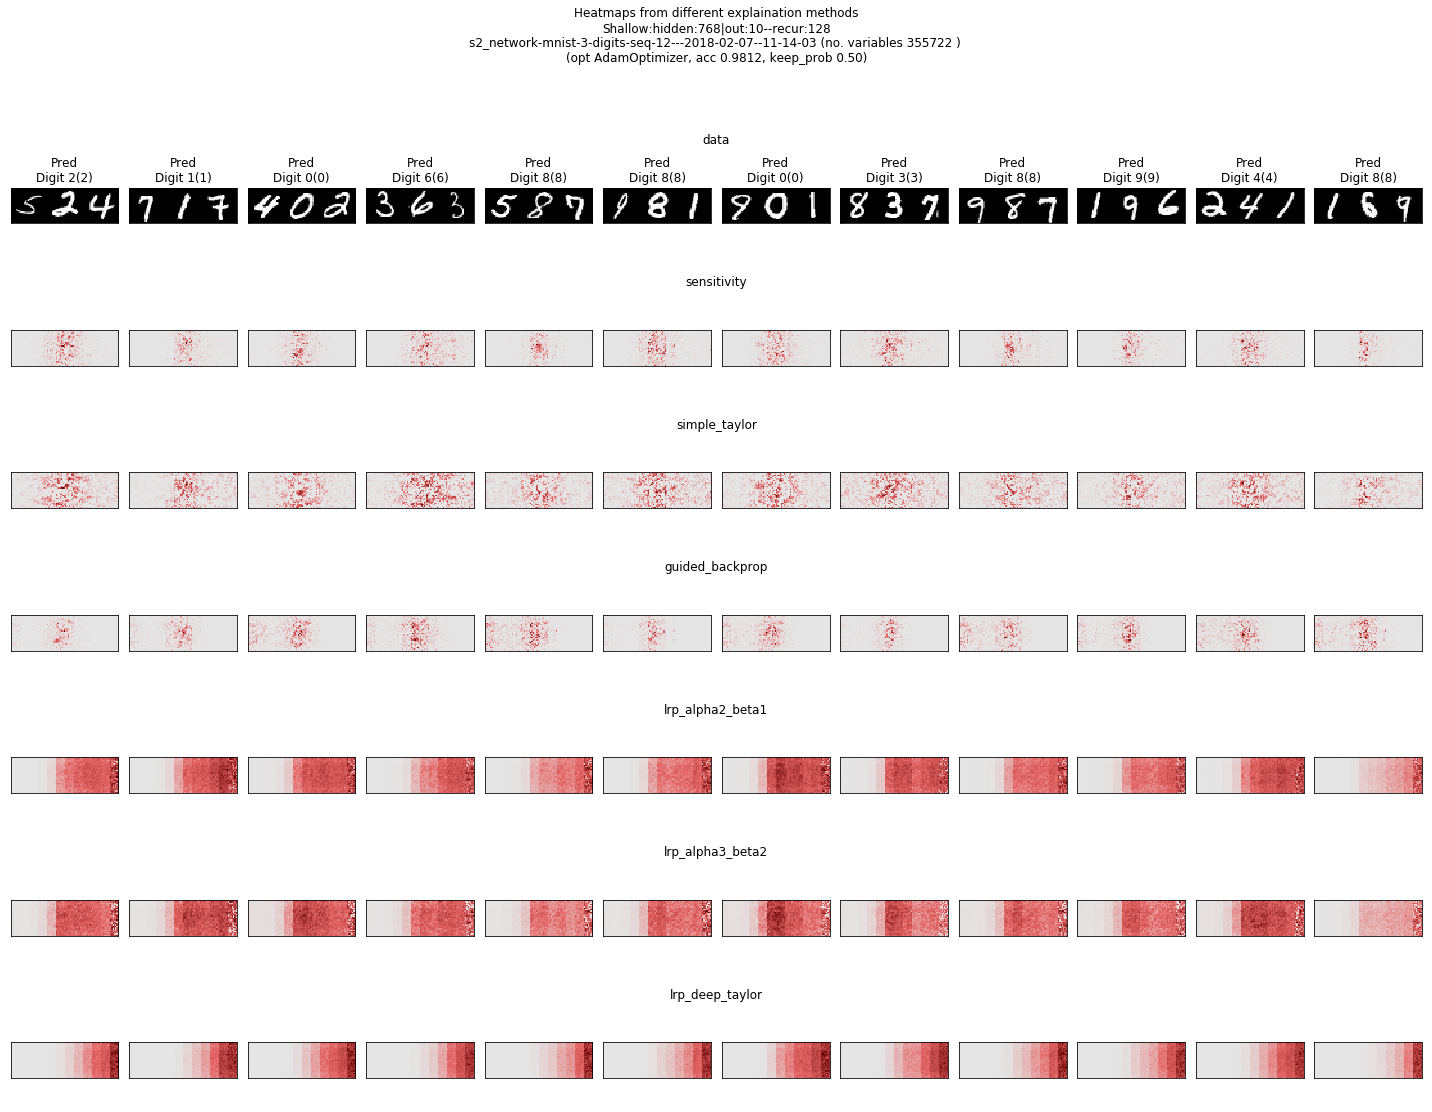

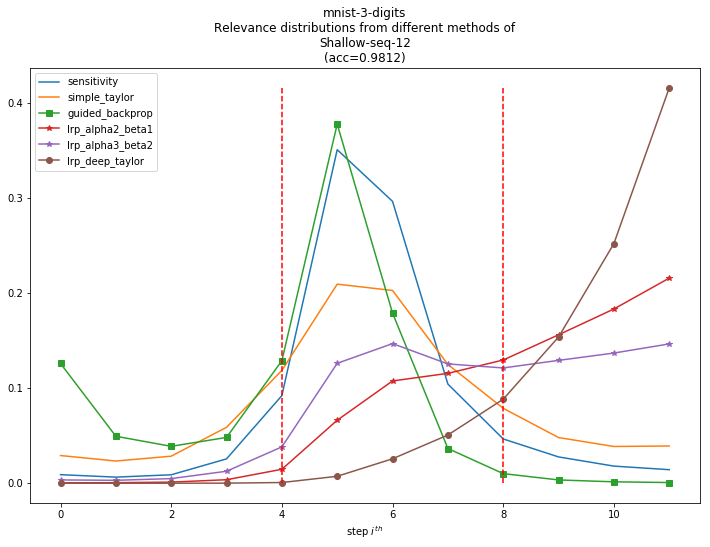

In [16]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/s2_network-mnist-3-digits-seq-12---2018-02-07--11-14-03")
plot_everything('s2', 'mnist-3-digits', 12)

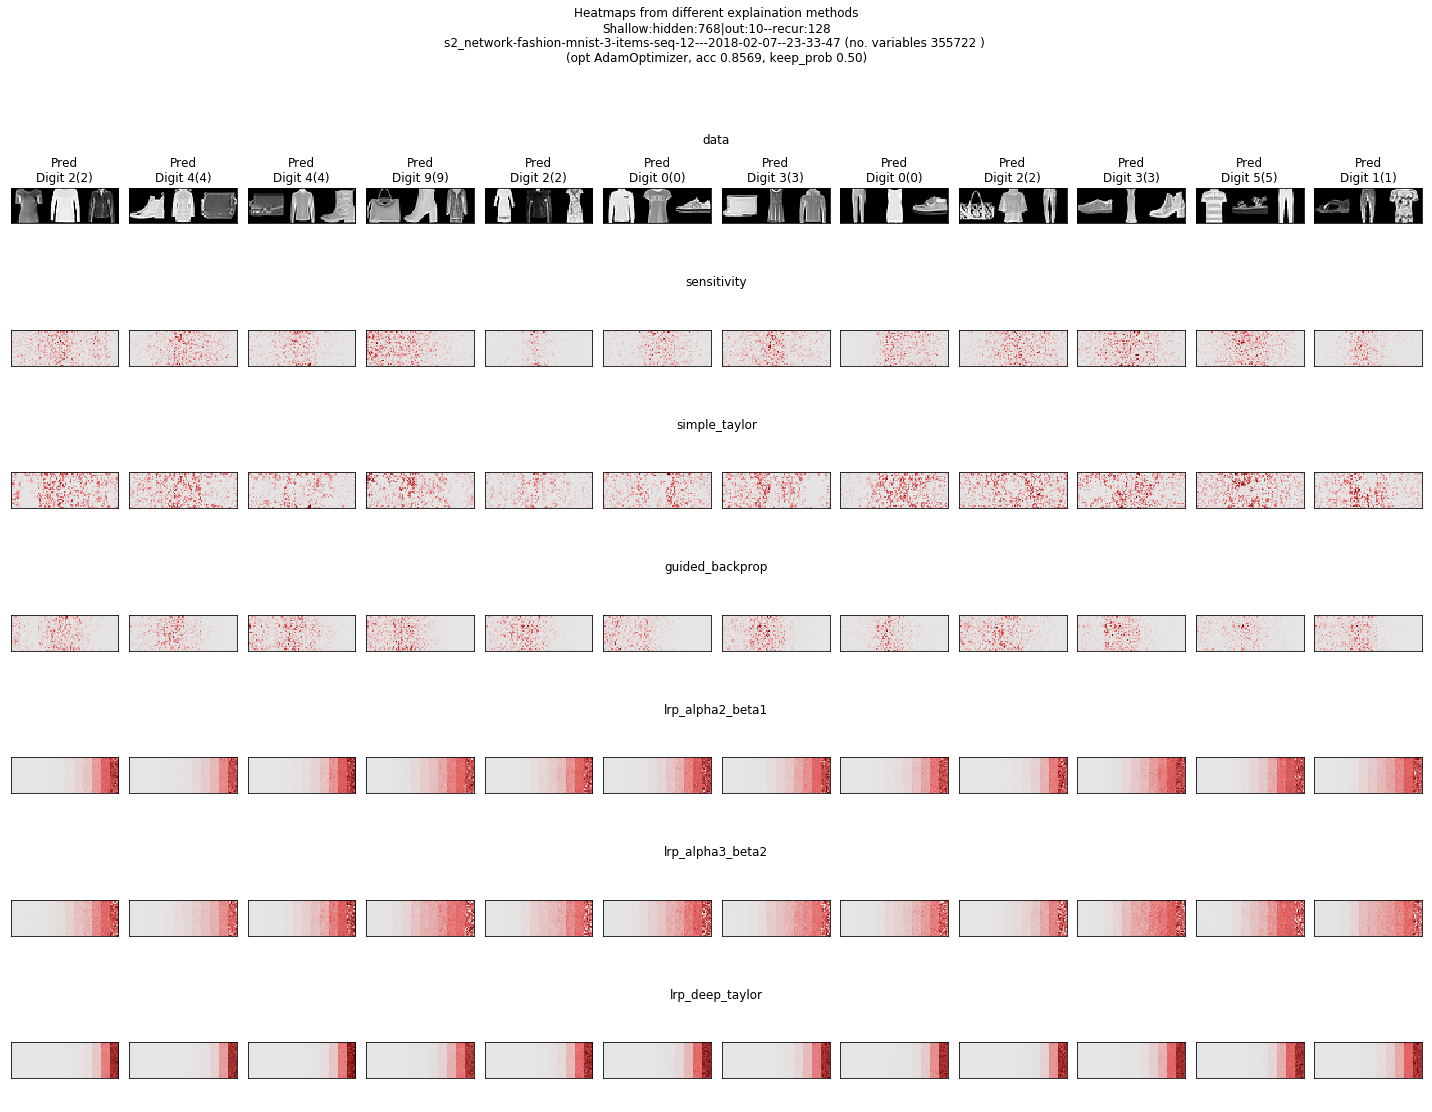

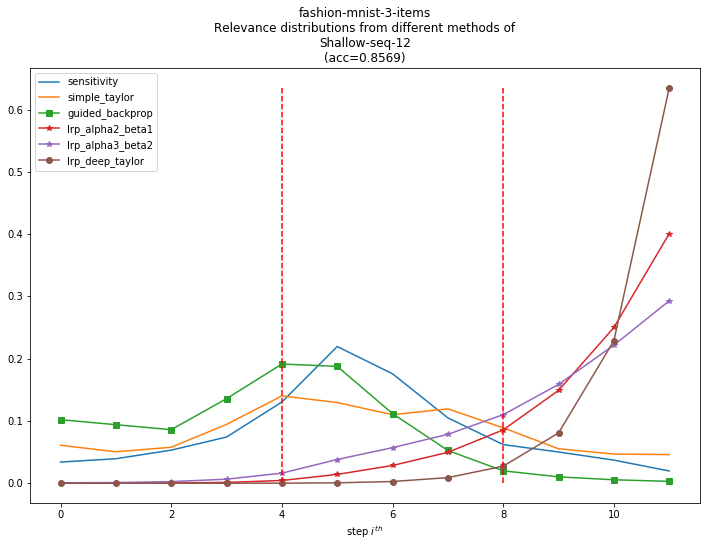

In [17]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/s2_network-fashion-mnist-3-items-seq-12---2018-02-07--23-33-47", data='fashion-mnist-3-items')
plot_everything('s2', 'fashion-mnist-3-items', 12)

## Deep architecture

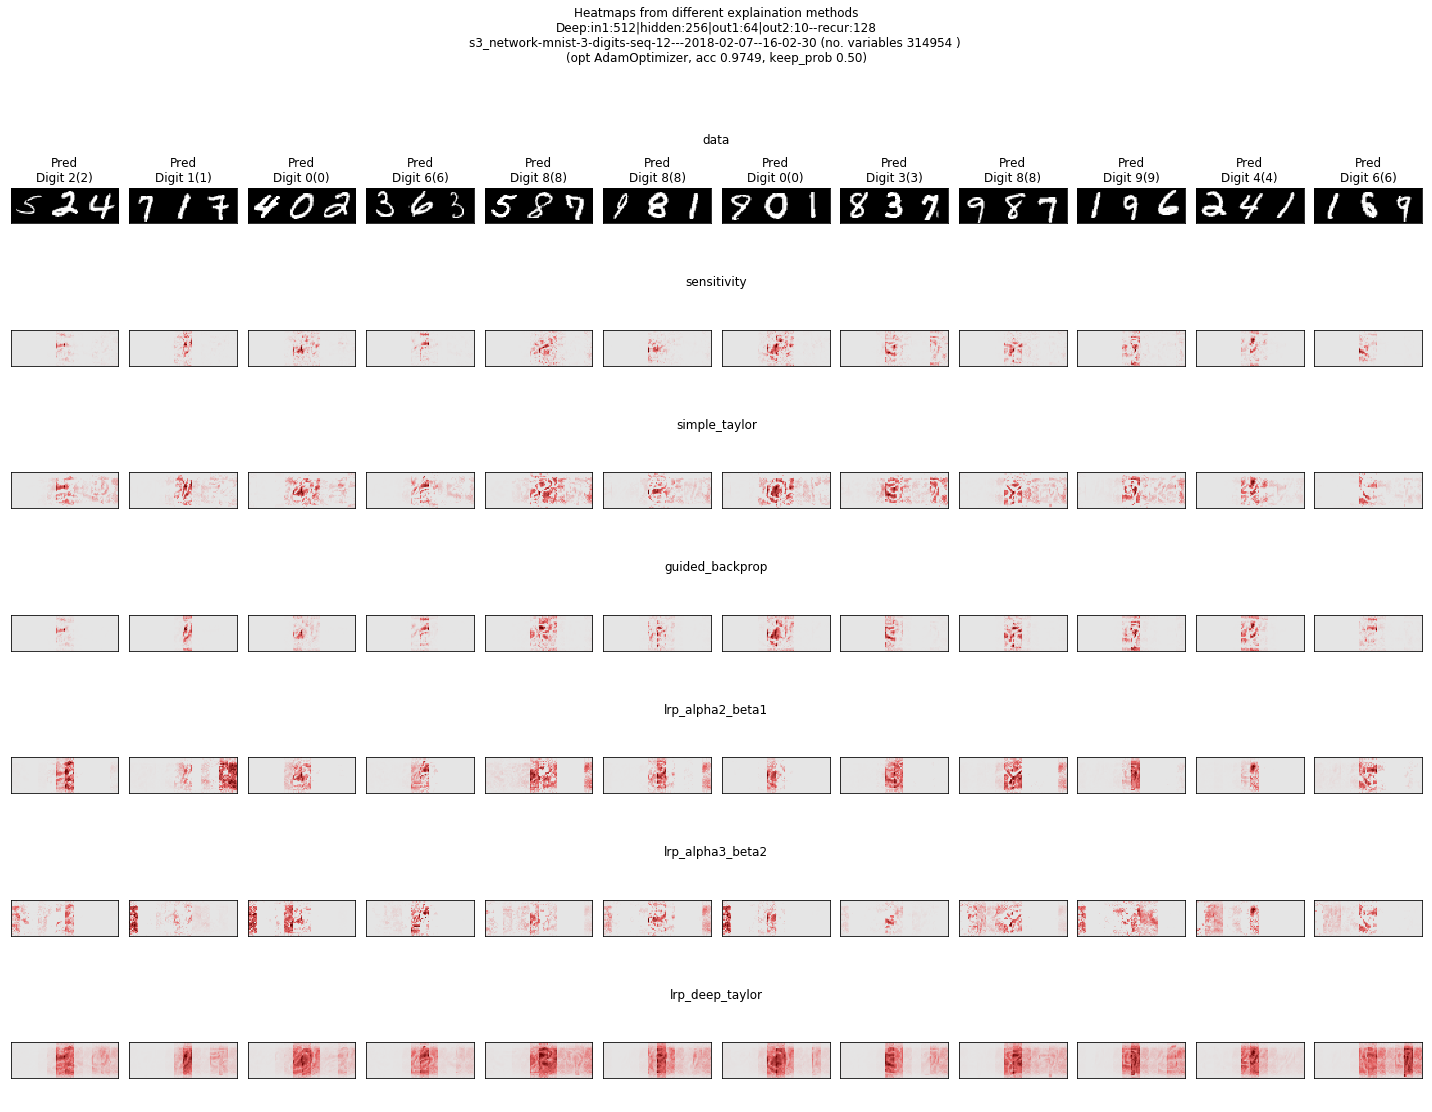

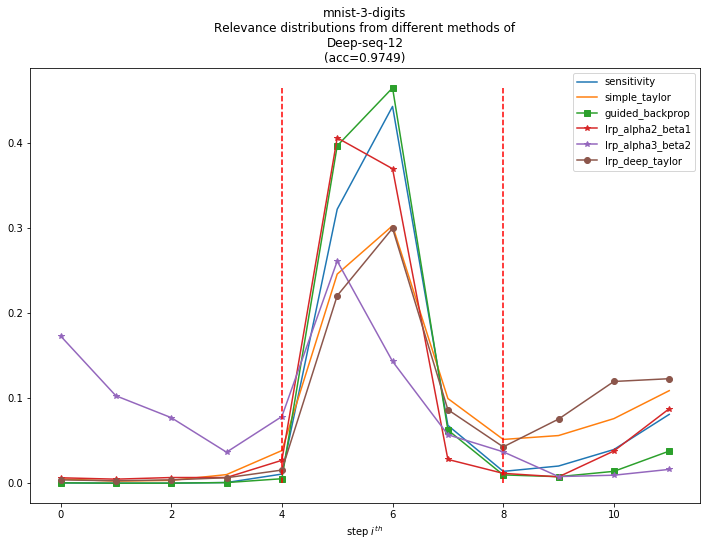

In [18]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/s3_network-mnist-3-digits-seq-12---2018-02-07--09-33-18") 
# plot_everything("../experiment-results/3-items-dataset/aws-training/s3_network-mnist-3-digits-seq-12---2018-02-07--16-02-30") 
plot_everything('s3', 'mnist-3-digits', 12)

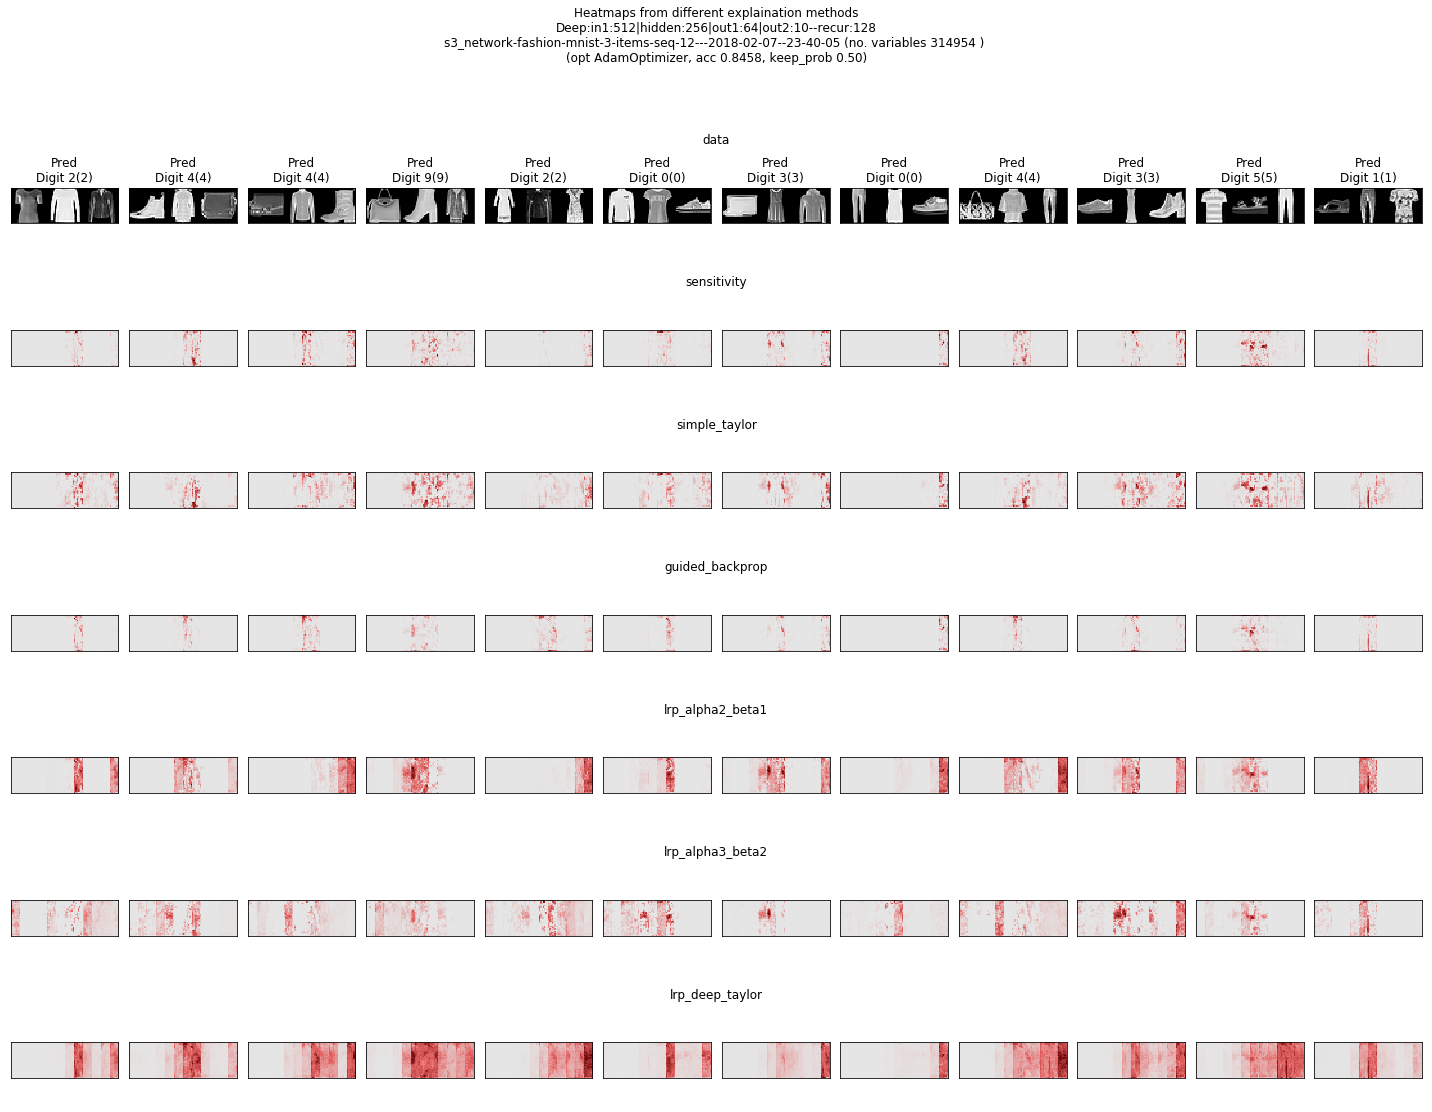

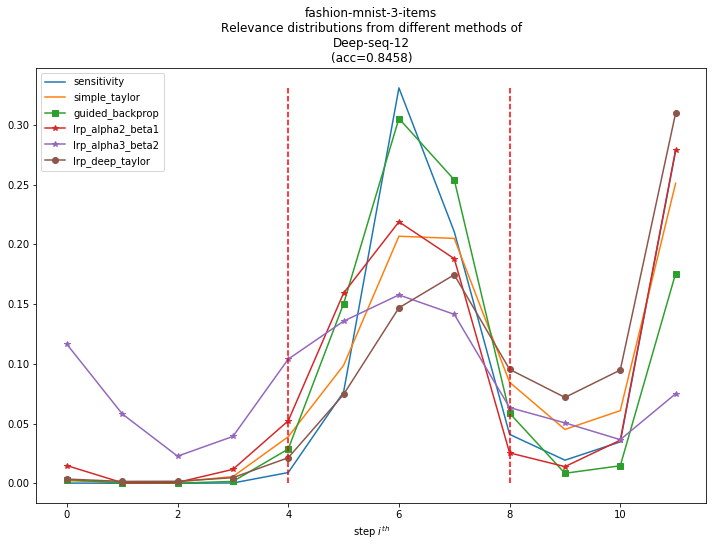

In [19]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/s3_network-fashion-mnist-3-items-seq-12---2018-02-07--23-40-05", data='fashion-mnist-3-items') 
plot_everything('s3', 'fashion-mnist-3-items', 12)

## DeepV2 architecture

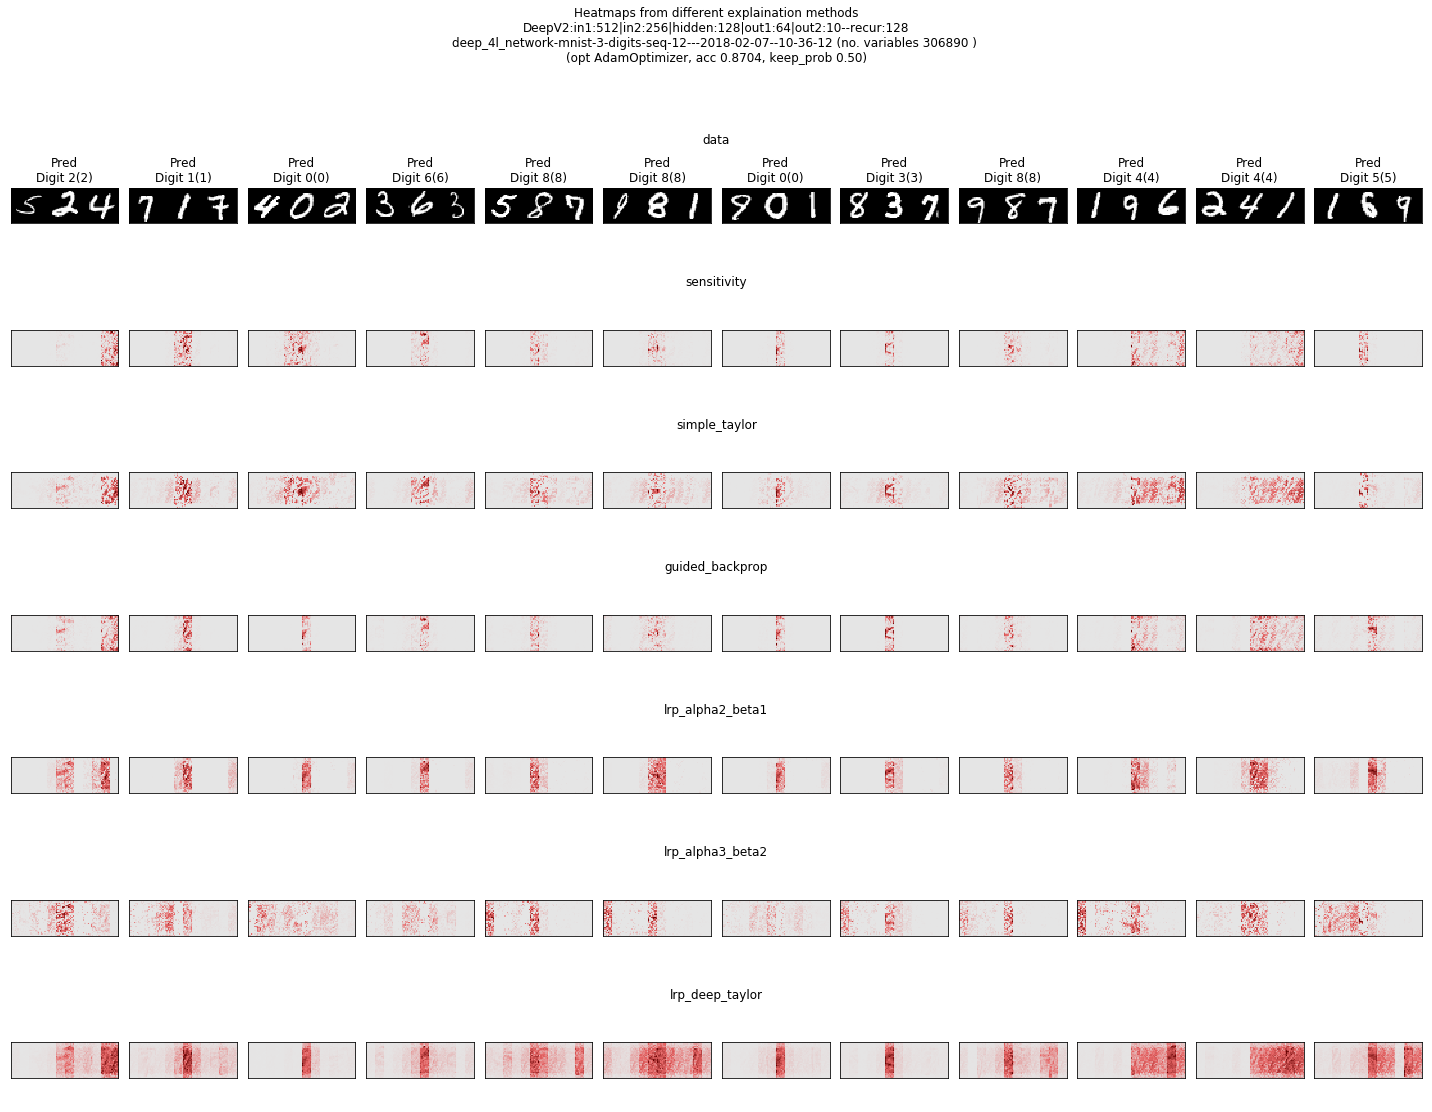

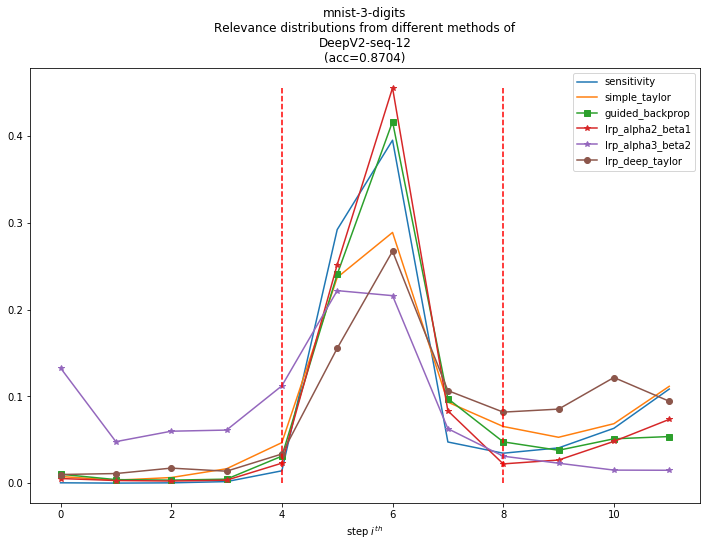

In [20]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/deep_4l_network-mnist-3-digits-seq-12---2018-02-07--10-36-12")
plot_everything('deep_4l', 'mnist-3-digits', 12)

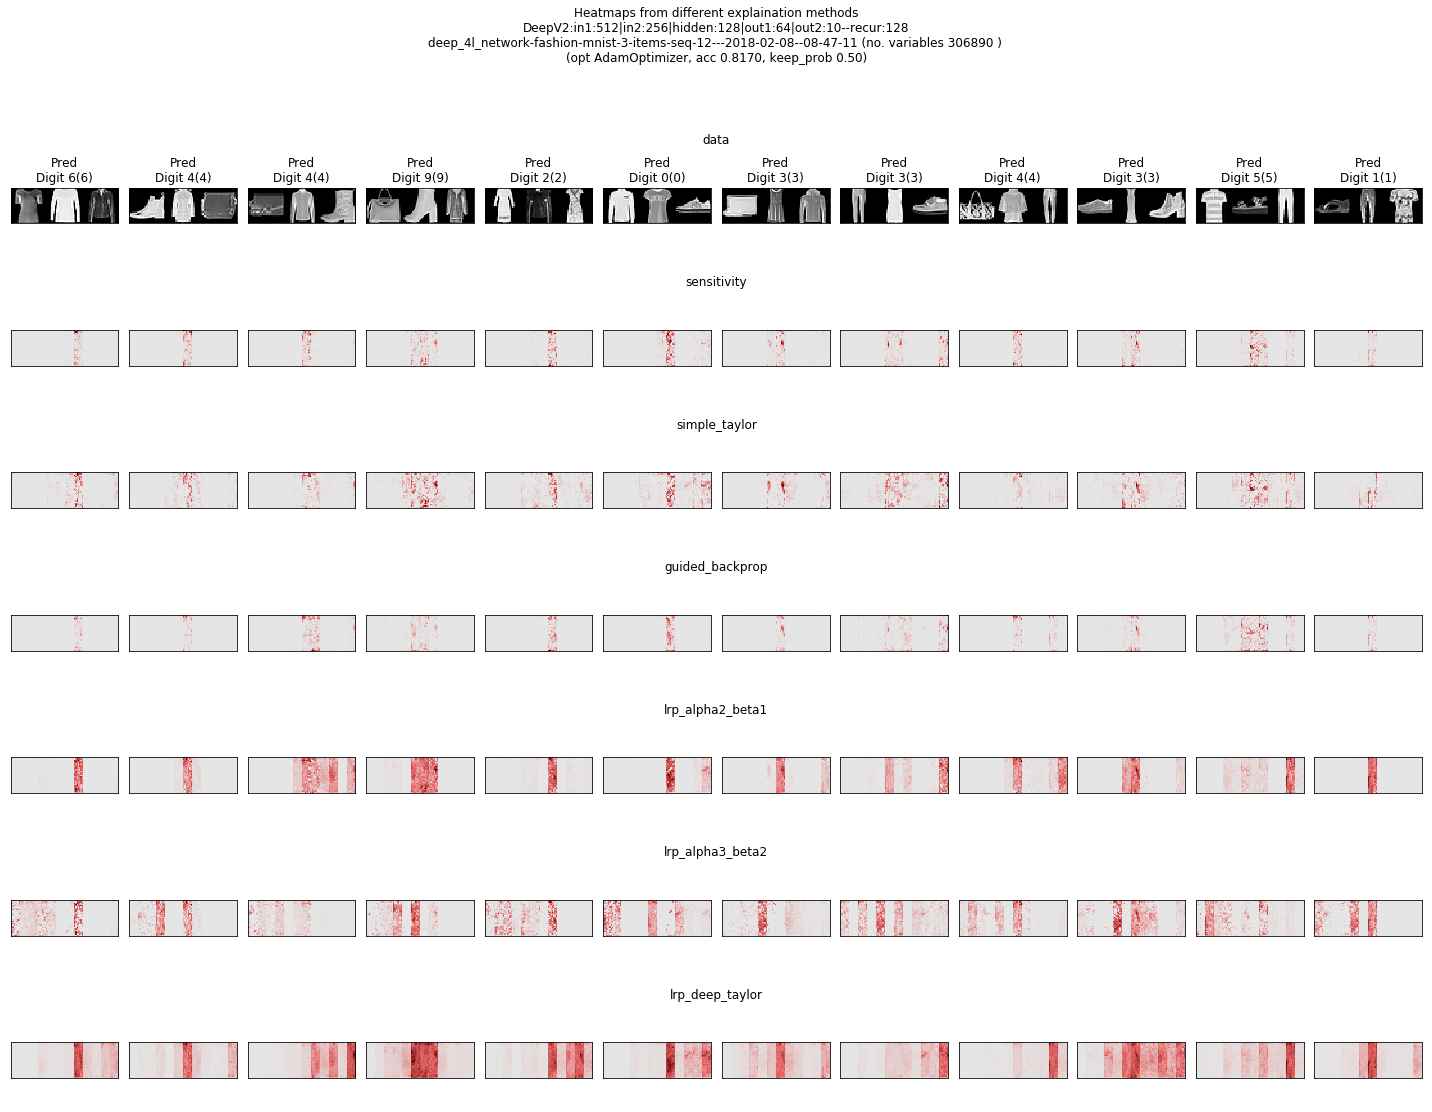

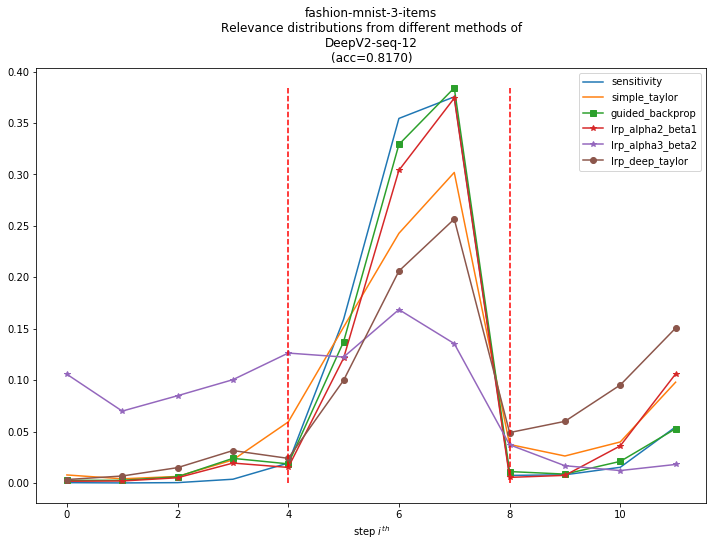

In [21]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/deep_4l_network-fashion-mnist-3-items-seq-12---2018-02-08--08-47-11", data='fashion-mnist-3-items')
plot_everything('deep_4l', 'fashion-mnist-3-items', 12)

## ConvDeep architecture

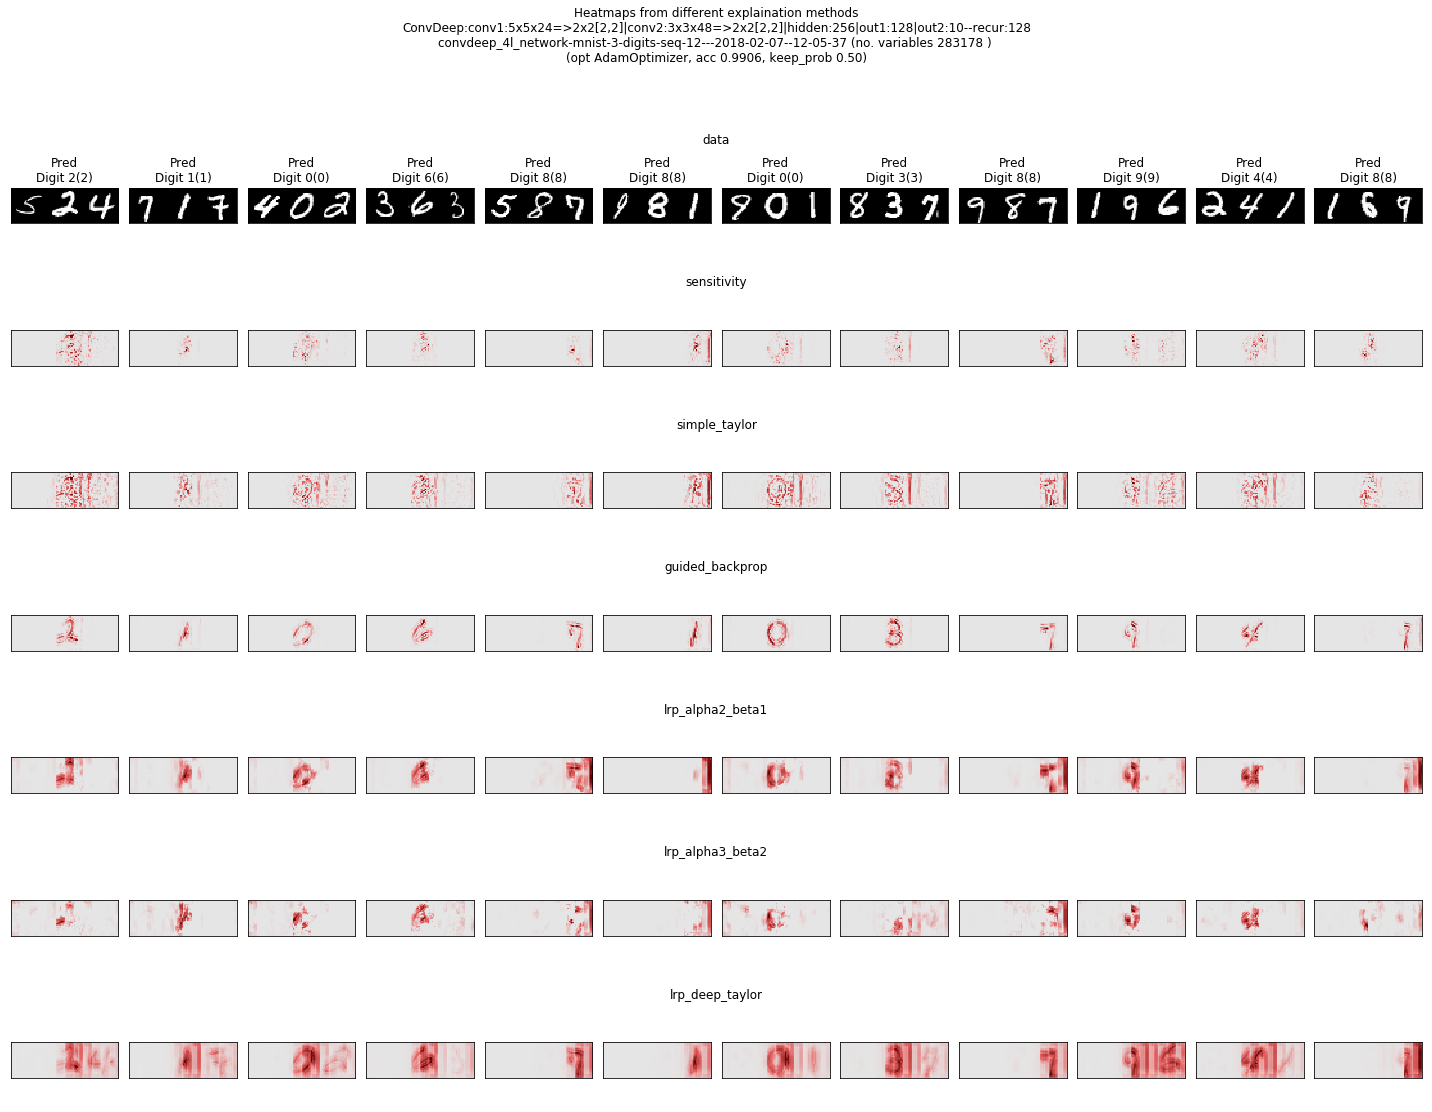

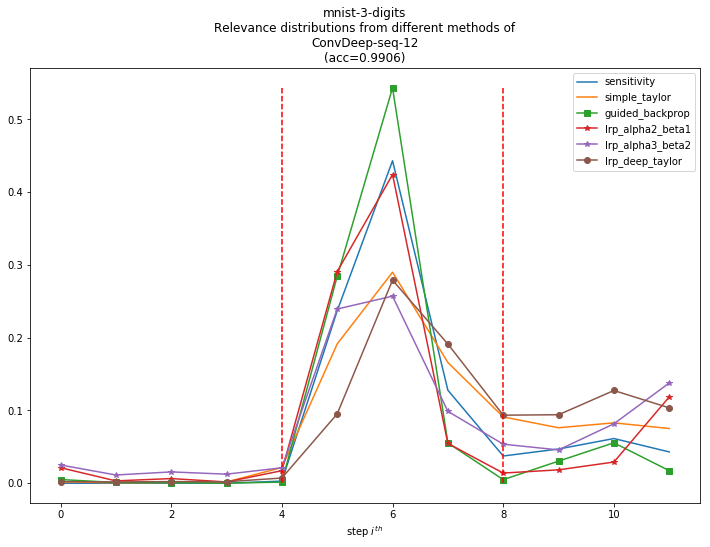

In [ ]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/convdeep_4l_network-mnist-3-digits-seq-12---2018-02-07--12-05-37")
plot_everything('convdeep_4l', 'mnist-3-digits', 12)

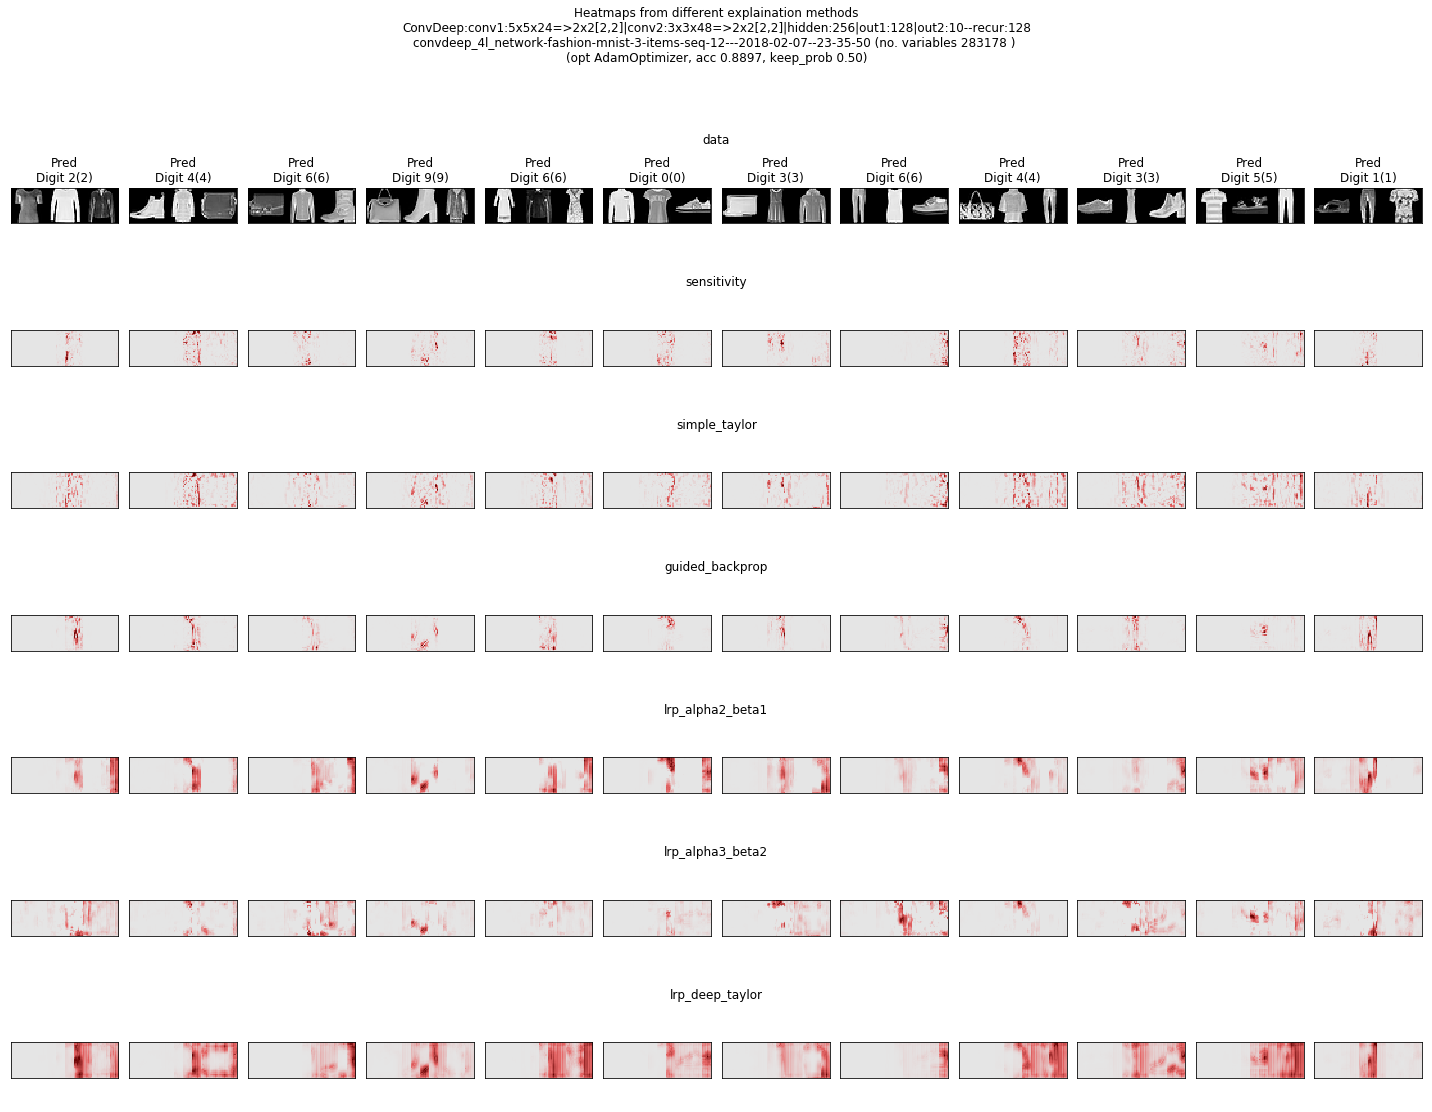

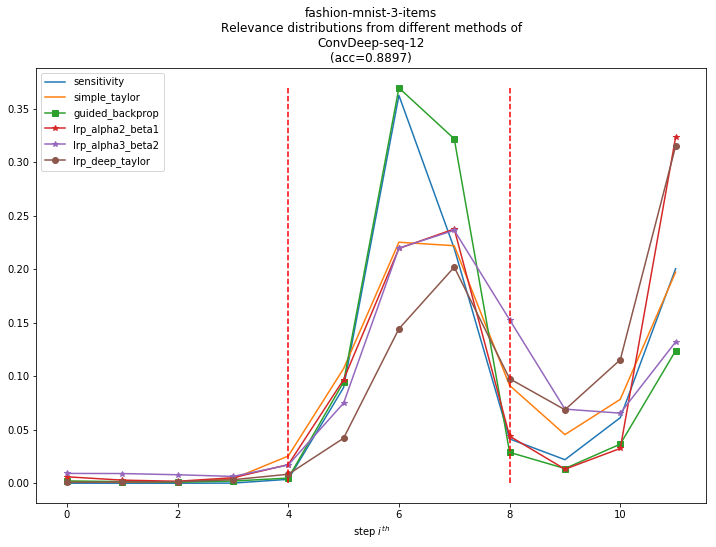

In [16]:
# plot_everything("../experiment-results/3-items-dataset/aws-training/convdeep_4l_network-fashion-mnist-3-items-seq-12---2018-02-07--23-35-50", data='fashion-mnist-3-items')
# # plot_everything(model_path('convdeep_4l', 'mnist-3-digits', 12))
plot_everything('convdeep_4l', 'fashion-mnist-3-items', 12)